# LIME - jieba 中文自動分词版本


## 導入模型、構建 explainer


In [ ]:
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np
import jieba
import string

device = "cuda"

# 加載模型和分詞器
peft_model_id = "CMLM/ZhongJing-2-1_8b"
base_model_id = "Qwen/Qwen1.5-1.8B-Chat"
model = AutoModelForCausalLM.from_pretrained(base_model_id, device_map="auto")
model.load_adapter(peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(
    peft_model_id, padding_side="right", trust_remote_code=True, pad_token=""
)

# Initialize conversation history
conversation_history = []


# 保存對話歷史版提問，用於首輪對話
def get_model_response(question):
    global conversation_history

    # Create the prompt with context
    prompt = f"Question: {question}"
    conversation_history.append({"role": "user", "content": prompt})
    messages = [
        {
            "role": "system",
            "content": "You are a helpful Traditional Chinese Medicine medical assistant.",
        },
    ] + conversation_history

    # Prepare the input
    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    # Generate the response
    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=512)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the response
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # 将模型的回复添加到对话历史中
    conversation_history.append({"role": "assistant", "content": response})

    return response


# 不保存對話歷史版提問，用於後續詞語分析
def get_model_response2(question):
    global conversation_history

    # Create the prompt without context
    prompt = f"Question: {question}"
    messages = (
        [
            {
                "role": "system",
                "content": "You are a helpful Traditional Chinese Medicine medical assistant.",
            },
        ]
        + conversation_history
        + [
            {"role": "user", "content": prompt},
        ]
    )

    # Prepare the input
    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    # Generate the response
    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=512)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the response
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response


def predictor(texts):
    results = []
    for text in texts:
        prompt = f'Question:"{text}" Question中的詞語对你生成中医回答相关, 则详细分析原因, 不相关则仅回答 0'
        # 創建消息格式
        messages = [
            {
                "role": "system",
                "content": "You are a helpful Traditional Chinese Medicine medical assistant.",
            },
            {"role": "user", "content": prompt},
        ]

        # 準備輸入
        formatted_text = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        inputs = tokenizer([formatted_text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits[0, -1], dim=-1)
            top_probs = torch.topk(probs, 2)
            prob_array = np.array(
                [top_probs.values[0].item(), top_probs.values[1].item()]
            )
            prob_array = prob_array / prob_array.sum()
            results.append(prob_array)

    # 可用手動調權重方法，但需要額外清洗數據集，遂放棄
    # with torch.no_grad():
    #     outputs = model(**inputs)
    #     logits = outputs.logits
    #     probs = torch.softmax(logits[0, -1], dim=-1)
    # # 基於模型輸出的機率
    # prob_array = np.array([probs[0].item(), probs[1].item()])

    # # 添加後處理邏輯
    # if any(keyword in text for keyword in ["诊断", "病症", "处方", "建议"]):
    #     prob_array[0] += 0.05  # 增強「相關」的機率
    #     prob_array[1] -= 0.05  # 減弱「不相關」的機率
    # else:
    #     prob_array[1] += 0.05  # 增強「不相關」的機率
    #     prob_array[0] -= 0.05

    # # 確保機率分佈合法（總和為 1）
    # prob_array = np.clip(prob_array, 0, 1)
    # prob_array /= prob_array.sum()

    # results.append(prob_array)

    return np.array(results)


# 自定義分詞函數
def chinese_tokenizer(text):
    # 使用 jieba 進行分詞
    words = jieba.cut(text, cut_all=False)

    # 定義要忽略的標點符號，可以擴展為包含中文標點
    punctuation = string.punctuation + "，。！？；：“”‘’（）《》、"

    # 過濾掉標點符號
    filtered_words = [word for word in words if word not in punctuation]

    return filtered_words


# 有標點符號版分詞，用於predictor
# def chinese_tokenizer_symbol(text):
#     # 使用 jieba 進行分詞
#     words = jieba.cut(text, cut_all=False)

#     return [word for word in words]


# 創建解釋器
explainer = LimeTextExplainer(
    class_names=["中医回答诊断结果相关", "中医回答诊断结果不相关"],
    split_expression=chinese_tokenizer,  # 使用jieba分詞
    bow=True,
    random_state=42,
)

In [2]:
# 測試predictor函數是否有效

test_texts_arr = [
    "这种病症需要进一步诊断。",  # 應該屬於 "相關"
    "今天天气如何？",  # 應該屬於 "不相關"
    "腹泻属于中医病症吗",
    "伤寒感冒会有中医的问题？",
    "天气影响了你的问诊回答吗？",
    "昨晚饮酒发热",
    "喝凉水数杯后胃疼",
    "舌苔白而腻，我是上火了吗",
    "腹痛腹泻，是中医上的哪种问题",
    "给出中医诊断和处方建议。",
    "饮酒腹痛原因",
    "天气不是中医诊断依据吗",
]


predictions = predictor(test_texts_arr)
print(predictions)

[[0.87668727 0.12331273]
 [0.58124551 0.41875449]
 [0.94024245 0.05975755]
 [0.56670432 0.43329568]
 [0.54449485 0.45550515]
 [0.79113372 0.20886628]
 [0.80412937 0.19587063]
 [0.91073933 0.08926067]
 [0.65154933 0.34845067]
 [0.8172394  0.1827606 ]
 [0.82038401 0.17961599]
 [0.50062274 0.49937726]]


## 定義自動換行函數


In [3]:
import textwrap


# 基本用法
def wrap_text(text, width=70):
    # 使用textwrap.fill()直接返回換行後的文本字符串
    wrapped_text = textwrap.fill(text, width=width)
    return wrapped_text


# 更多自定義選項的用法
def wrap_text_advanced(text, width=70, initial_indent="", subsequent_indent="  "):
    wrapper = textwrap.TextWrapper(
        width=width,  # 每行最大寬度
        initial_indent=initial_indent,  # 第一行縮進
        subsequent_indent=subsequent_indent,  # 後續行縮進
        break_long_words=True,  # 允許斷開長單詞
        break_on_hyphens=True,  # 允許在連字符處斷行
    )
    wrapped_text = wrapper.fill(text)
    return wrapped_text


# 示例文本
# text = "这是一段很长的中文文本，需要进行自动换行处理。通过使用Python的textwrap模块，我们可以轻松实现文本的自动换行功能，使得输出的文本更加整齐美观。"

# 基本換行
# print("基本換行示例：")
# print(wrap_text(text, width=20))

# print("\n高級換行示例：")
# print(wrap_text_advanced(text, width=20, initial_indent="    ", subsequent_indent="  "))

## 生成回答、生成解釋


In [4]:
print("\n=== 病人提問 ===")
# 測試文本
test_text = "张某，男，27岁。患者因昨晚饮酒发热，喝凉水数杯，早晨腹痛腹泻，大便如水色黄，腹中辘辘有声，恶心欲吐，胸中满闷不舒，口干欲冷饮，舌质红、苔白腻，脉沉细数。给出中医诊断和处方建议。"
print(wrap_text((test_text), width=30))


# 模型結果
print("\n=== 模型結果 ===")
response = get_model_response(test_text)
print(wrap_text(response, width=30))

# 生成解釋
explanation = explainer.explain_instance(
    text_instance=test_text,
    classifier_fn=predictor,
    num_features=len(chinese_tokenizer(test_text)),
    num_samples=1000,
    labels=[0, 1],
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== 病人提問 ===
张某，男，27岁。患者因昨晚饮酒发热，喝凉水数杯，早晨腹痛腹
泻，大便如水色黄，腹中辘辘有声，恶心欲吐，胸中满闷不舒，口干
欲冷饮，舌质红、苔白腻，脉沉细数。给出中医诊断和处方建议。

=== 模型結果 ===


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


中医诊断：伤食泄泻。 西医诊断：急性肠胃炎。其证型为湿热伤中
、脾胃失和、饮食不洁等导致的胃肠功能紊乱所致。 治疗原则：
1、辨证论治：在对症下药的基础上加减化裁。
2、饮食宜清淡、易消化。
3、多饮水、注意休息，避免劳累，避免寒凉食物刺激胃肠道。
4、如果出现腹胀，可以服用开瑞坦胶囊缓解症状。
5、一般情况下，在病情得到控制后，患者可自行恢复。 6、平时
要注重调理脾胃，多吃一些益气健脾的食物，例如山药、莲子、薏米
、小米、南瓜、玉米、白扁豆等。另外，还要保证规律的作息时间，
适当进行锻炼身体，以提高机体抵抗力，防止感冒或再次发生感染性
腹泻。


Loading model cost 0.517 seconds.
Prefix dict has been built successfully.


In [5]:
# 顯示解釋結果
explanation.show_in_notebook(labels=[0])

# print("\n=== 詞語重要性分析 ===")
# for word, importance in explanation.as_list():
#     print(f"詞語: {word:<20} 影響度: {importance:.4f}")

## 對分詞结果和詞語貢獻度自動提問


In [8]:
import json

output = []
output.append({"o_question": test_text, "o_response": response})

for word_weight in explanation.as_list():
    word, weight = word_weight
    if weight > 0:
        new_q = '词语"' + word + '"如何影响了你刚才首次中医诊断的回答？请逐步解释。'
        print("\n=== 病人提問 ===")
        print(wrap_text((new_q), width=30))

        print("\n=== 模型結果 ===")
        new_response = get_model_response2(new_q)
        print(wrap_text(new_response, width=30))
    else:
        new_q = (
            '结合我的首次提问，请逐步解释词语"'
            + word
            + '"为何对你刚才首次中医诊断的回答影响较小？我应该怎么样提问。'
        )
        print("\n=== 病人提問 ===")
        print(wrap_text((new_q), width=30))

        print("\n=== 模型結果 ===")
        new_response = get_model_response2(new_q)
        print(wrap_text(new_response, width=30))
    output.append(
        {"word": word, "weight": weight, "question": new_q, "response": new_response}
    )

json_output = json.dumps(output, ensure_ascii=False, indent=4)
# print("\n=== JSON 結果 ===")
# print(json_output)


=== 病人提問 ===
结合我的首次提问，请逐步解释词语"和"为何对你刚才首次中医诊
断的回答影响较小？我应该怎么样提问。

=== 模型結果 ===
“和”是中医的五味之一，指各种味道共同调配而成的协调、和谐状
态。“和”对于描述中医辨证施治时的阴阳、表里、虚实、寒热及补
泻等方面有着重要作用。“和”是指阴阳之间相互作用、相互依存、
互根互用的关系；在五味中，“和”是平衡性的，即偏于寒者能调和
于温、偏于热者能调和于寒；同时，阴阳之间的“和”不是绝对相等
的，而是相对的、动态的，不能把二者等同起来；因此，对于中医的
辩证方法而言，阴阳对立统一的关系就是相对的，而非绝对的。所以
，在分析病情的时候，要把握好此概念，切勿将阴和阳的概念混淆。
“和”对于疾病的诊断和辨证具有很重要的意义，所以，当医师提出
一个疾病诊断或辨证时，必须充分认识并理解这个概念。

=== 病人提問 ===
词语"处方"如何影响了你刚才首次中医诊断的回答？请逐步解释。

=== 模型結果 ===
《素问·脏气法时论》中记载：“病之有源而治则愈。”即疾病的发
生是由原因所导致的，所以治疗疾病必须从病因入手，通过药物作用
于病变部位，从而达到治愈目的。而本题所述的“处方”主要是指根
据患者的临床症状及体质情况，结合辨证理论，依据药物的功效特点
，选用合适的药物进行针对性治疗的方法，故能较好地解决患者的病
情，并有利于疾病的康复。

=== 病人提問 ===
结合我的首次提问，请逐步解释词语"27"为何对你刚才首次中医
诊断的回答影响较小？我应该怎么样提问。

=== 模型結果 ===
“27”通常指的是患者的年龄，也就是患者的年龄小于27岁的年
纪。对于年轻患者来说，年龄越小，则其疾病发作的几率越大，且病
情可能比较轻，相对来讲治愈的可能性会比较高。所以，患者年龄小
于27岁，对其疾病的判断更精确。

=== 病人提問 ===
结合我的首次提问，请逐步解释词语"脉沉"为何对你刚才首次中医
诊断的回答影响较小？我应该怎么样提问。

=== 模型結果 ===
“脉沉”就是指患者的脉象沉缓无力，这与上文的描述不符，所以就
对本病诊断的影响较小，此时我可以通过进一步追问相关资料，比如
患者的面色及舌苔，了解患者的实际情况，进而作出更准确的诊断。

=== 病人提問 ===
词语"细数"如何影响了你刚才首

## 對結果繪圖


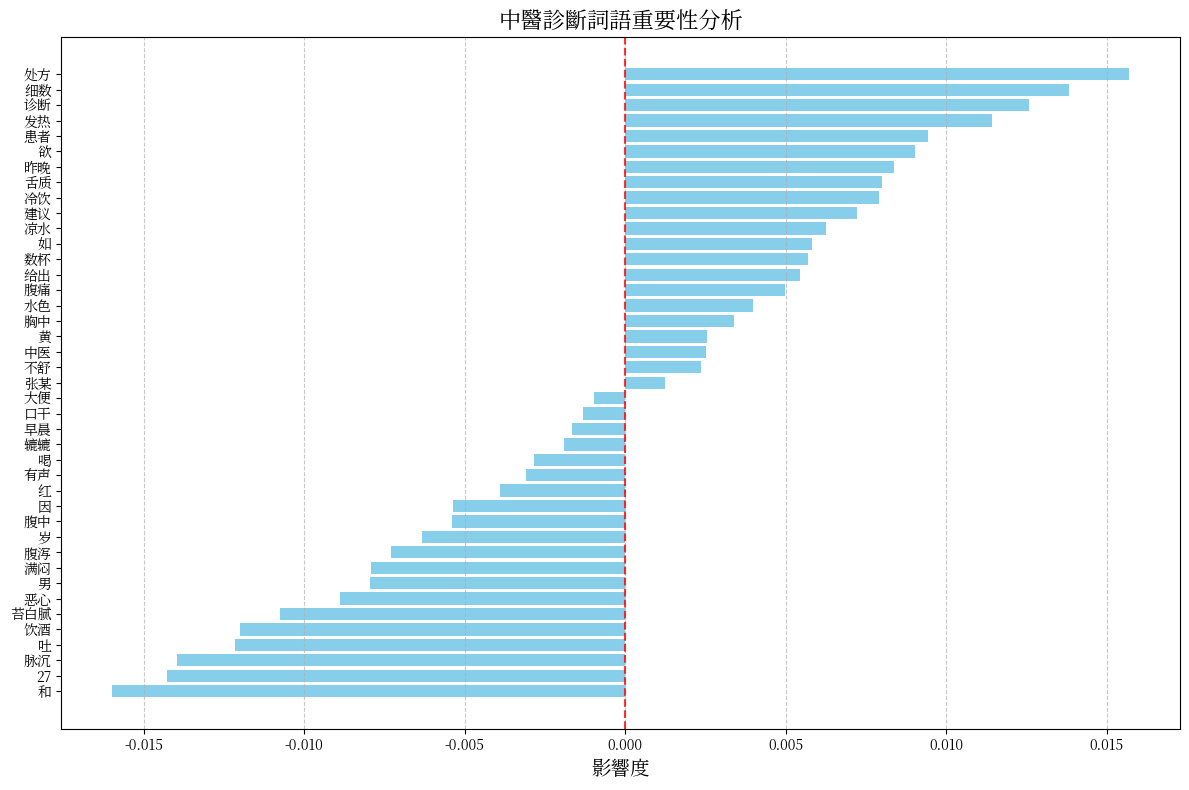

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# 設置全局字體為黑體
plt.rcParams["font.family"] = ["Noto Serif CJK JP"]
plt.rcParams["axes.unicode_minus"] = False

# 從explanation獲取結果並創建數據框
words_importance = explanation.as_list()
df = pd.DataFrame(words_importance, columns=["詞語", "影響度"])

# 按影響度排序
df = df.sort_values("影響度", ascending=True)

# 創建水平條形圖
plt.figure(figsize=(12, 8))
plt.barh(df["詞語"], df["影響度"], color="skyblue")

# 設置標題和標籤
plt.title("中醫診斷詞語重要性分析", fontsize=16)
plt.xlabel("影響度", fontsize=14)

# 添加參考線
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.axvline(x=0, color="red", linestyle="--", alpha=0.8)

# 添加註釋
# plt.text(
#     0.02, -1, "正值表示增加相關性\n負值表示降低相關性", fontsize=10, color="darkred"
# )

# 調整布局
# plt.xlim(-0.02 - 0.001, max(df["影響度"]) + 0.001)  # 調整x軸範圍，右側留些空間
plt.tight_layout()

# 保存圖片
# plt.savefig("lime_analysis.png", dpi=300, bbox_inches="tight")

# 顯示圖表
plt.show()